# 并行

本节介绍四种实现并发的方法：

- 节点并发
- `@task` 装饰器
- Map-reduce
- Sub-graphs

考虑到原文档大量使用 [parallelization（并行）](https://docs.langchain.com/oss/python/langgraph/workflows-agents#parallelization)这个词。为了尊重原文档，本节仍沿用「并行」作为题目。但必须提醒的是，由于全局解释器锁（GIL）的存在，LangGraph 主要实现的是「并发」，而不是真正的多核并行。

> **Note**
> 先回顾下 进程、线程、协程 的概念：
> - **进程（Process）**：操作系统资源分配的基本单位，拥有独立的内存空间和文件句柄。比如你开了微信、Chrome，每开一个 APP 就是一个进程。进程之间相互独立，内存不共享，因此谁挂了也不影响别人。但是进程创建和切换成本大，因为需要准备整套资源（内存、文件句柄等）。比喻：一个进程就是一栋房子，每个房子有自己的水电网。
> - **线程（Thread）**：进程里的执行流，多个线程共享同一个进程的内存和资源。因为共享内存，所以需要处理锁、同步和竞态问题。比喻：一栋房子里有许多小工人，共享房子的水电网。每个工人工作时需要独占 CPU 核心，但是多个工人可以在不同的 CPU 核心上同时工作。
> - **协程（Coroutine）**：用户态轻量级线程。由程序自己管理调度，而不是操作系统。它在线程内部运行，切换时无需进入内核态，因此开销极低。采用协作式调度，切换时需主动让出执行权（如`await`、`yield`）。因为能在等待 I/O 响应的间隙切换执行其他协程，所以非常适合 I/O 密集场景，比如网络请求、数据库操作等。比喻：工人在等待水烧开的间隙，去切菜、蒸米饭，不需要老板（操作系统内核）派活，可以自己看着办，效率极高。

> **Note**
> 再回顾下 并行、并发 的概念：
> - **并行（Parallelism）**：同一时刻多个任务真正同时执行，比如多核 CPU 一起跑多个任务。
> - **并发（Concurrency）**：同一时间段内多个任务交替执行，比如单核 CPU 通过时间片轮转交替运行多个程序。

In [1]:
import os
import time
import operator
import uuid

from dotenv import load_dotenv
from typing import Annotated
from datetime import datetime
from pydantic import BaseModel
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Send
from langgraph.func import entrypoint, task
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor

# 加载模型配置
_ = load_dotenv()

# 加载模型
model_name = "qwen3-max"
llm = ChatOpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    model=model_name,
    temperature=0.7,
)

## 一、节点并发

节点并发很容易实现，使用 `StateGraph` 创建带并发行节点的工作流就可以。

下面是一个简单的节点并发的例子。你可以观察节点运行的时间戳，确认它们是否真的在并发。

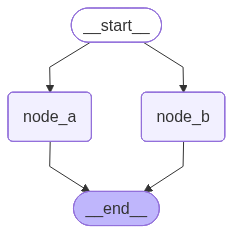

In [2]:
# 创建并发节点a
def node_a(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_a] 进入函数时间: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # 使用 sleep 模拟占用时间
    time.sleep(2)

    end_time = datetime.now()
    print(f"[node_a] 退出函数时间: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'节点a运行了{round((end_time - start_time).total_seconds(), 3)}秒'
    )]}

# 创建并发节点b
def node_b(state: MessagesState):
    start_time = datetime.now()
    print(f"[node_b] 进入函数时间: {start_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    # 使用 sleep 模拟占用时间
    time.sleep(4)

    end_time = datetime.now()
    print(f"[node_b] 退出函数时间: {end_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")

    return {'messages': [HumanMessage(
        content=f'节点b运行了{round((end_time - start_time).total_seconds(), 3)}秒'
    )]}

# 创建图
builder = StateGraph(MessagesState)

# 添加节点
builder.add_node('node_a', node_a)
builder.add_node('node_b', node_b)

# 添加边
builder.add_edge(START, 'node_a')
builder.add_edge(START, 'node_b')
builder.add_edge('node_a', END)
builder.add_edge('node_b', END)

# 编译图
my_graph = builder.compile(name='my-graph')
my_graph

In [3]:
# 调用图
response = my_graph.invoke({
    'messages': [HumanMessage(content='执行 node_a 和 node_b')]
})

for message in response['messages']:
    message.pretty_print()

[node_a] 进入函数时间: 2025-12-12 21:04:04.928
[node_b] 进入函数时间: 2025-12-12 21:04:04.928
[node_a] 退出函数时间: 2025-12-12 21:04:06.933
[node_b] 退出函数时间: 2025-12-12 21:04:08.933
================================ Human Message =================================

执行 node_a 和 node_b
================================ Human Message =================================

节点a运行了2.006秒
================================ Human Message =================================

节点b运行了4.005秒


> **Note**
> 
> 若想了解节点的执行顺序，推荐阅读 [parallelization.ipynb](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb).

## 二、使用 `@task` 实现并发

`@task` 装饰的 `generate_paragraph` 函数会创建多个可并发的任务节点。

In [4]:
# 创建可并发的任务节点
@task
def generate_paragraph(topic: str) -> str:
    response = llm.invoke([
        {"role": "system", "content": "你是一个会写科普文的智能助手"},
        {"role": "user", "content": (
            f"写一个关于{topic}的段落，大约100字。"
            "你写的内容只是整篇文章的一个段落"
            "因此请聚焦给定话题，不需要概述性文字")}
    ])
    return response.content

`@entrypoint` 装饰的 `workflow` 函数会变成工作流的入口。额外配置的 `checkpointer` 使该工作流具备失败恢复功能。

In [5]:
# 创建持久化检查点
checkpointer = InMemorySaver()

# 并发生成多个段落并将它们组合起来
@entrypoint(checkpointer=checkpointer)
def workflow(topics: list[str]) -> str:
    # 将 topic 分发到多个任务节点，并发执行
    futures = [generate_paragraph(topic) for topic in topics]
    paragraphs = [f.result() for f in futures]
    return "\n\n".join(paragraphs)

# 运行工作流
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
result = workflow.invoke(["海胆豆腐是什么", "海胆豆腐有多美味", "海胆豆腐的原料和做法"], config=config)
print(result)

海胆豆腐并非传统意义上的豆腐，而是一道融合日式与中式烹饪理念的创意料理。它通常以嫩滑的内酯豆腐为基底，铺上新鲜海胆（uni），利用豆腐的清淡衬托海胆的鲜甜与浓郁奶油感。有时还会加入少许酱油、柚子汁或葱花提味，整体口感细腻柔润，突出海洋食材的天然风味。

海胆豆腐的妙处，在于鲜与嫩的极致交融。温润如玉的嫩豆腐轻轻托着金黄海胆，入口瞬间，海胆的甘甜海洋气息在舌尖绽放，带着微微的奶香与矿物鲜味，而豆腐则如云朵般化开，温柔地承接住这份奢华。两者相融，不抢不夺，只余下满口清鲜滑润，仿佛把整片澄澈海水都含在了嘴里。

海胆豆腐的主要原料包括新鲜海胆黄、嫩豆腐、姜末和高汤。做法是先将嫩豆腐切块焯水去腥，再与温热高汤一同入锅小火煨煮；随后轻轻铺上海胆黄，撒少许姜末提鲜，避免沸腾以免海胆变老，稍煮片刻即可出锅，保持海胆的鲜甜与豆腐的滑嫩。


## 三、Map-reduce

学过 [Hadoop](https://www.luochang.ink/posts/hadoop_intro/) 的人都知道，map-reduce 是一个「先并行，后归约」的过程。这个概念被借鉴到 Agent 这里，变成了「先发散，后收敛」。借鉴过来之后，它的内涵其实变简单了，简单到不用 LangGraph 也能实现。那为什么还要用 LangGraph 呢？当然是因为用 LangGraph 写的 map-reduce 更标准化，可读性也更强一些。

> **Note**
> 🙆 八卦的心，就是爱（编程）的魔法。

下面从一个非常实际的问题入手：女神不回消息怎么办！！！

我们来创建几种人设：

- 男神
- 巨魔
- 舔狗
- 渣男
- 奶狗弟弟
- 社恐宅男
- 霸道总裁
- 茶茶的男生 💅💅💅
- 文艺长发男
- 萌萌二次元

你一定非常好奇，这些人会如何应对。下面我们来揭秘。

### 1）创建上下文的 schema

In [6]:
# 角色
class Roles(BaseModel):
    roles: list[str]

# 单个角色
class Role(BaseModel):
    role: str

# 单个回复
class Response(BaseModel):
    response: str

# 最佳回复的 ID
class BestResponse(BaseModel):
    id: int

# 全局上下文
class Overall(TypedDict):
    roles: list[str]
    responses: Annotated[list, operator.add]
    best_response: str

### 2）创建提示词模版

In [7]:
# 角色的提示词
role_prompt = "女神又不回你消息了，作为一个{role}，你应该如何一句话回复女神？请以JSON格式返回，包含response字段"

# 最佳回复的提示词
best_response_prompt = """下面是几种类型的男生，面对女神不回消息的情况，做出的反应。
你觉得以下哪种回复最能挽回女神的心，请返回对应的ID。
注意哦，第一条反应对应的是0号ID。并以JSON格式返回，包含id字段
下面是男生们的反应：\n\n{responses}"""

### 3）创建节点

这里的魔法在于我们使用 [Send](https://docs.langchain.com/oss/python/langgraph/graph-api#send) 函数，将角色分发给 `generate_response` 节点进行角色回复生成。

In [8]:
# 使用 Send 函数分发角色
def continue_to_responses(state: Overall):
    return [ Send("generate_response", {"role": r}) for r in state["roles"] ]

# 角色回复节点：生成每个角色的回复
def generate_response(state: Role):
    prompt = role_prompt.format(role=state["role"])
    response = llm.with_structured_output(Response).invoke(prompt)
    return {"responses": [response.response]}

# 最佳回复节点：返回最佳回复
def best_response(state: Overall):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {"best_response": state["responses"][response.id]}

> **Note**
> 我们允许 `generate_response` 节点的 `state` 的 schema 与上游节点不同。因为 `generate_response` 节点是并发执行的，所以这个 schema 是特殊的，不需要与全局 schema（`Overall`）相同。

### 4）编译图

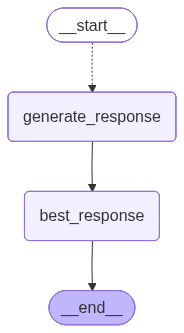

In [9]:
# 定义Doge子图的输出Schema
class DogeOutput(TypedDict):
    roles: list[str]
    responses: list[str]
    best_response: str

# 创建图
doge_builder = StateGraph(Overall, output_schema=DogeOutput)

# 添加节点
doge_builder.add_node("generate_response", generate_response)
doge_builder.add_node("best_response", best_response)

# 添加边
doge_builder.add_conditional_edges(START, continue_to_responses, ["generate_response"])
doge_builder.add_edge("generate_response", "best_response")
doge_builder.add_edge("best_response", END)

# 编译图
doge_graph = doge_builder.compile(name='best-response')
doge_graph

In [10]:
# 调用图
roles = ["男神", "巨魔", "舔狗", "渣男", "奶狗弟弟", "社恐宅男",
         "霸道总裁", "茶茶的男生 💅💅💅", "文艺长发男", "萌萌二次元"]
response = doge_graph.invoke({"roles": roles})

In [11]:
# 最佳回复
print(f"最受 {model_name} 喜爱的回复：{response['best_response']}")

最受 qwen3-max 喜爱的回复：看来我的消息又在你的已读列表里迷路了，要不要我派个导航过去接它？😉


In [12]:
# 所有回复
for role, resp in zip(response["roles"], response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【男神】
看来我的消息又在你的已读列表里迷路了，要不要我派个导航过去接它？😉

【巨魔】
看来我的消息又在女神的已读不回区排队了，要不要给我发个排队号？

【舔狗】
好的，你忙吧，不打扰你了。

【渣男】
刚在忙，没看到消息，不过你一出现，其他事都不重要了。

【奶狗弟弟】
姐姐是不是在忙呀？不着急回我，但我会一直乖乖等你的～

【社恐宅男】
刚刚在打游戏/看番，看到消息有点紧张，不知道该怎么回你才好……你还好吗？

【霸道总裁】
看来我的消息在你那儿成了VIP——永远排队等回复。不过，我给你最后一次机会：三分钟内不回，我就亲自上门问你是不是手机坏了。

【茶茶的男生 💅💅💅】
宝～是在忙吗？茶茶等你回消息等到指甲都快抠秃噜皮啦💅💔

【文艺长发男】
风起时，长发拂过未读的对话框，我在诗行间等你回眸，哪怕只是一句‘在’。

【萌萌二次元】
呜...女神大人是不是在忙呀？(๑•̀ㅂ•́)و✧ 我会乖乖等你回消息的！



## 四、Sub-graphs

已经写好的图，可以放到父图里面作为 **子图**（Sub-graphs）调用。这意味着我们可以复用已经写好的图。

> **Note**
> 不是哥们！女神不回消息这个话题真好用吧！让我们继续这个话题。

上一节创建的图 `doge_graph` 只产出了一条“最佳”回复，这真的够吗？罒ω罒

不够不够，必须再加一个工作流以策万全！

### 1）创建一个工作流

下面我们创建一个工作流。它不像 `doge_graph` 那样需要指定人设，而是可以自动生成 `n` 个新人设，再生成这些人设的回复。

In [13]:
# 定义ReAct子图的全局Schema
class ReActState(TypedDict):
    roles: list[str]
    n: int
    new_roles: list[str]
    responses: list[str]

# 发散性地生成角色
def generate_roles(state: ReActState):
    roles = "、".join(state["roles"])
    n = state["n"]
    prompt = (
        "现在进行一个角色扮演游戏，内容是：当女神不回消息时，如何挽回女神。"
        f"参考角色列表：{roles}，再创造{n}个不同的角色。"
        "你将在稍后扮演这些角色，回女神消息。"
        "请以json格式返回，包含roles字段。"
        f"roles字段必须是纯字符串数组，元素为新创造的{n}个角色名称。"
        "只返回一个JSON对象，不要包含任何解释或其他文本。"
    )
    res = llm.with_structured_output(Roles).invoke(prompt)
    return {"new_roles": res.roles}

def role_response(role: str) -> str:
    prompt = role_prompt.format(role=role)
    res = llm.with_structured_output(Response).invoke(prompt)
    return res.response

def divergent_thinking(state: ReActState):
    with ThreadPoolExecutor(max_workers=8) as executor:
        rs = list(executor.map(role_response, state["new_roles"]))
    return {"responses": rs}

> **Note**
> 感觉 LangGraph 把并发写复杂了，用 [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) 写也许更简单。

将上面的节点连接起来，组成工作流。

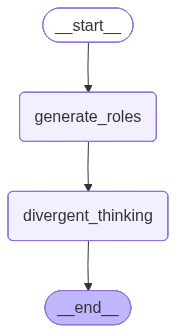

In [14]:
# 定义ReAct子图的输出Schema
class ReActOutput(TypedDict):
    new_roles: list[str]
    responses: list[str]

# 创建图
react_builder = StateGraph(
    state_schema=ReActState,
    output_schema=ReActOutput
)

# 添加节点
react_builder.add_node('generate_roles', generate_roles)
react_builder.add_node('divergent_thinking', divergent_thinking)

# 添加边
react_builder.add_edge(START, 'generate_roles')
react_builder.add_edge('generate_roles', 'divergent_thinking')
react_builder.add_edge('divergent_thinking', END)

# 编译图
react_graph = react_builder.compile(name='divergent-thinking')
react_graph

### 2）测试工作流

运行这个工作流，看看结果是否符合预期。

In [15]:
# 调用图
res = react_graph.invoke({"roles": roles, "n": 5})

assert len(res["new_roles"]) == len(res["responses"])

for role, resp in zip(res["new_roles"], res["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【佛系养生男】
随缘不扰，静待花开；你若安好，便是晴天。

【电竞热血少年】
女神在打排位？等你回我消息，就像我在决赛圈等空投一样执着！

【高冷哲学诗人】
沉默是深渊的回响，而我，早已习惯在无言中凝视星辰。

【甜酷街头潮人】
啧，女神又在玩消失？行吧，等你上线，我的酷可不等人太久哦～

【温柔治愈系学长】
没关系呀，等你有空的时候再回我就好，我一直都在～



### 3）并发运行两个子图

现在我们有两个工作流：`doge_graph` 和 `react_graph`，下面将它们并联起来，放进一个父图之中。

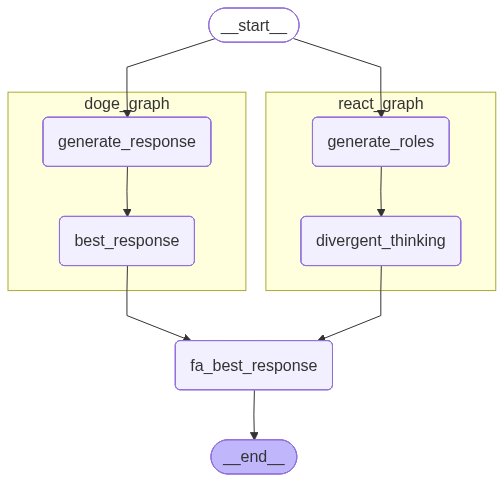

In [16]:
# 父图的全局Schema
class EntryGraphState(TypedDict):
    roles: list[str]
    n: int
    new_roles: list[str]
    responses: Annotated[list, operator.add]
    best_response: str

# 父图的最佳回复节点：返回最佳回复，并聚合roles
def fa_best_response(state: EntryGraphState):
    responses = "\n\n".join(state["responses"])
    prompt = best_response_prompt.format(responses=responses)
    response = llm.with_structured_output(BestResponse).invoke(prompt)
    return {
        "roles": state["roles"] + state["new_roles"],
        "best_response": state["responses"][response.id]
    }

# 创建父图
fa_builder = StateGraph(EntryGraphState)

# 添加节点
fa_builder.add_node("doge_graph", doge_builder.compile())
fa_builder.add_node("react_graph", react_builder.compile())
fa_builder.add_node("fa_best_response", fa_best_response)

# 添加边
fa_builder.add_edge(START, "doge_graph")
fa_builder.add_edge(START, "react_graph")
fa_builder.add_edge("doge_graph", "fa_best_response")
fa_builder.add_edge("react_graph", "fa_best_response")
fa_builder.add_edge("fa_best_response", END)

# 编译图
fa_graph = fa_builder.compile(name='father-graph')

# 将 xray 参数设为 1 会显示嵌套图的内部结构
display(Image(fa_graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
# 调用图
response = fa_graph.invoke({"roles": roles[3:6], "n": 5})

这里的最佳回复，是从两个子图的所有回复中产生的最佳回复。你觉得它的质量变高了吗？( ﾟ∀。)

In [18]:
# 最佳回复
print(f"最受 {model_name} 喜爱的回复：{response['best_response']}")

最受 qwen3-max 喜爱的回复：没关系呀，等你有空再回我就好，不着急～


In [19]:
# 所有回复
assert len(response["roles"]) == len(response["responses"]), f'{len(response["roles"])} != {len(response["responses"])}'

for role, resp in zip(response["roles"], response["responses"]):
    print(f"【{role}】")
    print(resp)
    print()

【渣男】
刚在忙，没看到消息，不过你一上线我就秒回了——毕竟对你，我从来都不是渣男，只是太在意你的感受。

【奶狗弟弟】
姐姐是不是在忙呀？不着急回我，但我会一直乖乖等你的～

【社恐宅男】
刚刚在打游戏/看番，看到消息有点紧张，不知道怎么回才好……你还好吗？

【高冷霸总】
看来我的时间，还不值得你浪费一句回复。

【文艺诗人】
若你如月隐云后，我便作夜风轻叩；不扰清辉，只待回眸。

【搞笑段子手】
女神，我刚去银河系客服投诉了，说你已读不回影响宇宙和平，他们让我转告你：再不回消息，我就要启动‘舔狗超新星爆发’模式了！

【温柔学长】
没关系呀，等你有空再回我就好，不着急～

【神秘占卜师】
星辰沉默，非因冷漠，而是命运正为你编织一场更盛大的重逢。

